In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates
from datetime import datetime


from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from scipy import stats

%matplotlib inline

# Context

- Walmart is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas (Wikipedia).
 
- In Retail Industry, sales is the most important metric in their business model that make profit. On this reason, sales analysis will be a good way in determining business operation.

- In this dataset, We'll do analyse how Walmart Sales looks like (Trend and Seasonal) and explain wether available feature (macroeconomic condition) would be affecting it using Econometric Panel Regression (Fixed Effect and Random Effect).

# Data Description 

This dataset contain 8 available feature:
1. Store: the store number
2. Date - the week of sales
3. Weekly_Sales: sales for the given store
4. Holiday_Flag: whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
5. Temperature: temperature on the day of sale
6. Fuel_Price: cost of fuel in the region
7. CPI: prevailing consumer price index
8. Unemployment: prevailing unemployment rate


Holiday Events
1. Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
2. Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
3. Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
4. Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [2]:
df = pd.read_csv('Data\Walmart_Store_sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [6]:
df.duplicated().any()

False

Luckily we have clean dataset that not containing null values, duplicate rows.

In [7]:
years = dates.YearLocator()
months = dates.MonthLocator()
years_fmt = dates.DateFormatter('%b %Y')

df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y')

#for simplicity, we use 1k unit in sales
df['Weekly_Sales'] = round(df['Weekly_Sales'] / 1000, 3)
df['CPI'] = round(df['CPI'], 2)

df2 = df.copy()

#build panel data sorting by store and date
df2 = df2.sort_values(by = 'Date')
pivot = pd.pivot_table(df2, values = ['Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'], index = ['Store', 'Date']).reset_index()
pivot['Month'] = pivot['Date'].dt.month
pivot['Year'] = pivot['Date'].dt.year

pivot.head()

,Store,Date,CPI,Fuel_Price,Holiday_Flag,Temperature,Unemployment,Weekly_Sales,Month,Year
0,1,2010-02-05,211.10,2.572,0,42.31,8.106,1643.691,2,2010
1,1,2010-02-12,211.24,2.548,1,38.51,8.106,1641.957,2,2010
2,1,2010-02-19,211.29,2.514,0,39.93,8.106,1611.968,2,2010
3,1,2010-02-26,211.32,2.561,0,46.63,8.106,1409.728,2,2010
4,1,2010-03-05,211.35,2.625,0,46.50,8.106,1554.807,3,2010


In [8]:
pivot.drop(['Month', 'Year', 'Store'], axis = 1).describe()

,CPI,Fuel_Price,Holiday_Flag,Temperature,Unemployment,Weekly_Sales
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,171.578468,3.358607,0.069930,60.663782,7.999151,1046.964876
std,39.356697,0.459020,0.255049,18.444933,1.875885,564.366622
min,126.060000,2.472000,0.000000,-2.060000,3.879000,209.986000
25%,131.740000,2.933000,0.000000,47.460000,6.891000,553.350000
50%,182.620000,3.445000,0.000000,62.670000,7.874000,960.746000
75%,212.745000,3.735000,0.000000,74.940000,8.622000,1420.158500
max,227.230000,4.468000,1.000000,100.140000,14.313000,3818.686000


# A. Aggregate Time Series Analysis

# How is the Walmart aggregate sales looks like? Does this sales has seasonal component?

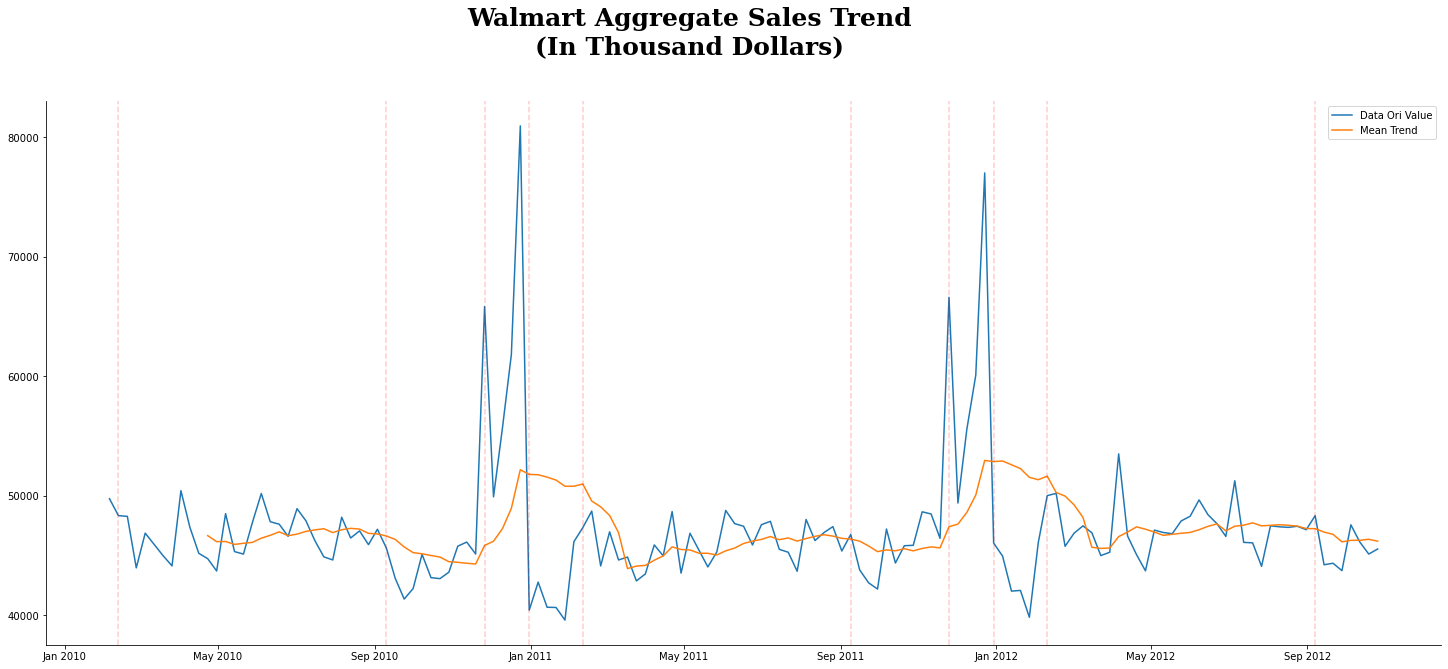

In [9]:
#Aggregate Sales for the whole Walmart Store

agg_sales = pivot.groupby('Date')['Weekly_Sales'].sum().reset_index()

fig, ax = plt.subplots(1, 1, figsize = (25, 10))
sns.lineplot(x = agg_sales['Date'], y = agg_sales['Weekly_Sales'], ax = ax, label = 'Data Ori Value', palette = 'viridis')
sns.lineplot(x = agg_sales['Date'], y = agg_sales['Weekly_Sales'].rolling(12).mean(), ax = ax, label = 'Mean Trend',
            palette = 'viridis')
holiday_date = ['2010-02-12', '2010-09-10',
       '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09',
       '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07']
for i in holiday_date:
    ax.axvline(i, color = 'r', alpha = 0.2, ls='--')
    
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
ax.text('2011-05-06', 87000, 'Walmart Aggregate Sales Trend\n(In Thousand Dollars)', fontsize = 25, fontweight = 'bold', 
        fontfamily = 'serif', color = 'black', ha = 'center')
ax.set_ylabel('')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(years_fmt)

plt.show()

In [10]:
agg_sales['Date'][142]

Timestamp('2012-10-26 00:00:00')

The graph tell us that this data contain seasonal component on holiday date (red line). Walmart sales seems rapidly increased when holiday date taking place. But in the other side (non-holiday date), sales tend to be in stagnant position. It means we have to be careful interpreting sales volume (Growth sales would be good metrics). Before that, next we'll discuss more little depth which holiday contribute more in Walmart sales aggregately.

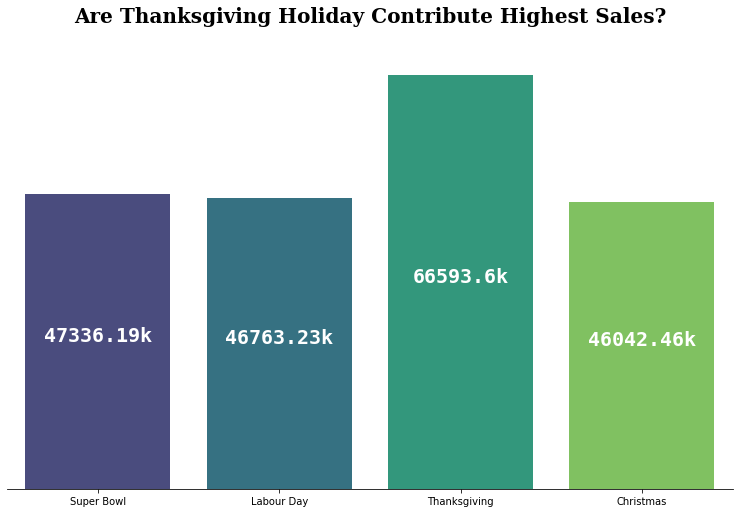

In [11]:
#Detail about sales in holiday, are thanksgiving holiday have highest sales?

#Defining specific holiday
super_bowl = ['2010-02-12', '2011-02-11', '2012-02-10']
labour_day = ['2010-09-10', '2011-09-09', '2012-09-07']
thanksgiving = ['2010-11-26', '2011-11-25', '2012-11-23']
christmas = ['2010-12-31', '2011-12-30', '2012-12-28']

super_bowl_sales = df[df['Date'] == '2011-02-11']['Weekly_Sales'].sum()
labour_day_sales = df[df['Date'] == '2011-09-09']['Weekly_Sales'].sum()
thanksgiving_sales = df[df['Date'] == '2011-11-25']['Weekly_Sales'].sum()
christmas_sales = df[df['Date'] == '2011-12-30']['Weekly_Sales'].sum()

data = {'Super Bowl': super_bowl_sales,'Labour Day': labour_day_sales, 
        'Thanksgiving': thanksgiving_sales,'Christmas': christmas_sales}

holiday_sales = round(pd.Series(data),2)

fig, ax = plt.subplots(1, 1, figsize=(13, 8))
sns.barplot(x = holiday_sales.index, y = holiday_sales, ax = ax, palette = 'viridis')

for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)
ax.set_yticks([])
ax.set_ylabel('')
for ind, val in enumerate(holiday_sales):
    ax.text(x = ind, y = val/2, s = f'{str(val)}k', fontsize = 20, fontweight = 'bold', ha = 'center', 
            fontfamily = 'monospace', color = 'white')
ax.text(1.5, 75000, 'Are Thanksgiving Holiday Contribute Highest Sales?', fontsize = 20, fontweight = 'bold', 
            fontfamily = 'serif', color = 'black', ha = 'center')

plt.show()

In [12]:
pivot_table = pd.pivot_table(pivot, values = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], 
                             index = 'Date', aggfunc = {'Weekly_Sales': np.sum, 'Temperature': np.mean, 'Fuel_Price': np.mean,
                                                        'CPI': np.mean, 'Unemployment': np.mean}).reset_index()
pivot_table['Month'] = pivot_table['Date'].dt.month
pivot_table['Year'] = pivot_table['Date'].dt.year
pivot_table.head()

,Date,CPI,Fuel_Price,Temperature,Unemployment,Weekly_Sales,Month,Year
0,2010-02-05,167.729778,2.717844,34.037333,8.619311,49750.741,2,2010
1,2010-02-12,167.826889,2.694022,34.151333,8.619311,48336.676,2,2010
2,2010-02-19,167.873778,2.672067,37.719778,8.619311,48276.996,2,2010
3,2010-02-26,167.910444,2.683933,39.243556,8.619311,43968.572,2,2010
4,2010-03-05,167.949111,2.731200,42.917333,8.619311,46871.469,3,2010


We see here that 

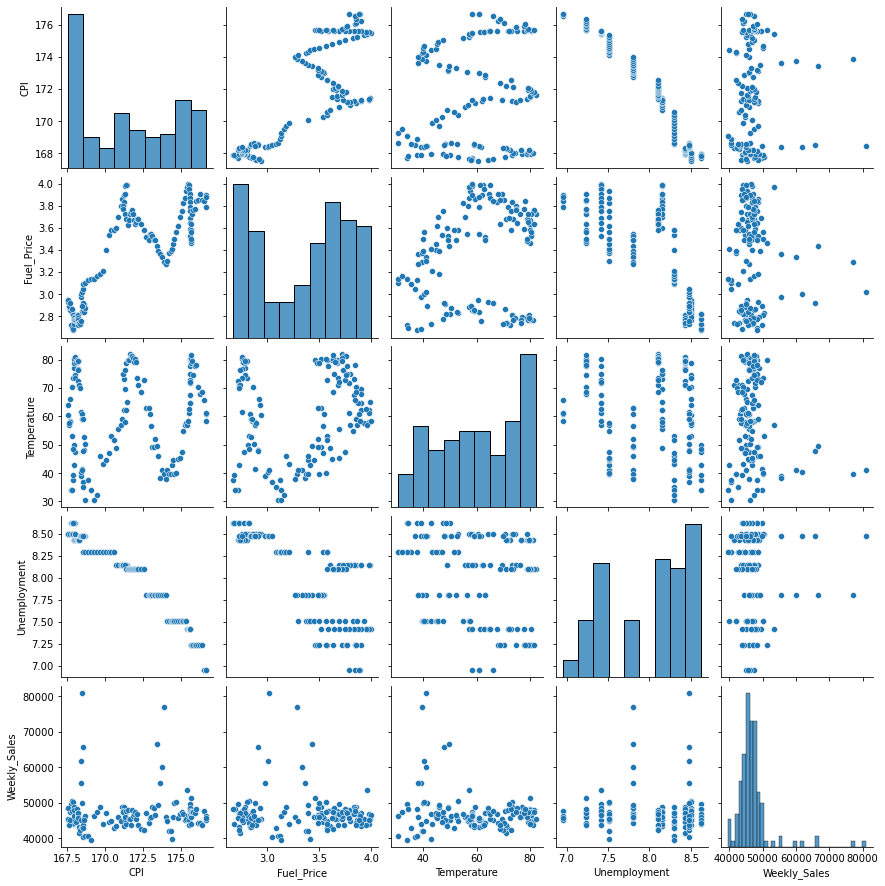

In [13]:
sns.pairplot(pivot_table.drop(['Month', 'Year'], axis = 1))

In [14]:
pivot_table.drop(['Month', 'Year'], axis = 1).corr()

,CPI,Fuel_Price,Temperature,Unemployment,Weekly_Sales
CPI,1.000000,0.824693,0.159415,-0.977429,0.023393
Fuel_Price,0.824693,1.000000,0.205757,-0.747205,-0.056722
Temperature,0.159415,0.205757,1.000000,-0.168460,-0.159160
Unemployment,-0.977429,-0.747205,-0.168460,1.000000,0.003524
Weekly_Sales,0.023393,-0.056722,-0.159160,0.003524,1.000000


It seems that sales have less correlation with macroeconomic condition. Possible reason of this realtionship that because we use weekly data and macroeconomic variables like CPI, unemployment, fuel price have slow/rigid change in the short run.

In [15]:
growth_df = pivot[['Date', 'Weekly_Sales']].resample('M', on = 'Date').sum().reset_index()
growth_df['Rolling_Month'] = np.roll(growth_df['Weekly_Sales'], 1)
growth_df['Growth_MoM'] = round((growth_df['Weekly_Sales'] - growth_df['Rolling_Month']) / growth_df['Rolling_Month'] * 100, 2)
grotwh_df = growth_df.shift(-1)
growth_df['Year'] = growth_df['Date'].dt.year
growth_df['Month'] = growth_df['Date'].dt.month

super_bowl = ['2010-02-28', '2011-02-28', '2012-02-28']
labour_day = ['2010-09-30', '2011-09-30', '2012-09-30']
thanksgiving = ['2010-11-30', '2011-11-30', '2012-11-30']
christmas = ['2010-12-31', '2011-12-31', '2012-12-31']

g2010 = growth_df[growth_df['Year'] == 2010][['Month', 'Growth_MoM']].max()
g2011 = growth_df[growth_df['Year'] == 2011][['Month', 'Growth_MoM']].max()
g2012 = growth_df[growth_df['Year'] == 2012][['Month', 'Growth_MoM']].max()

Text(1.3, 0.1, '2012')

findfont: Font family ['sanserif'] not found. Falling back to DejaVu Sans.


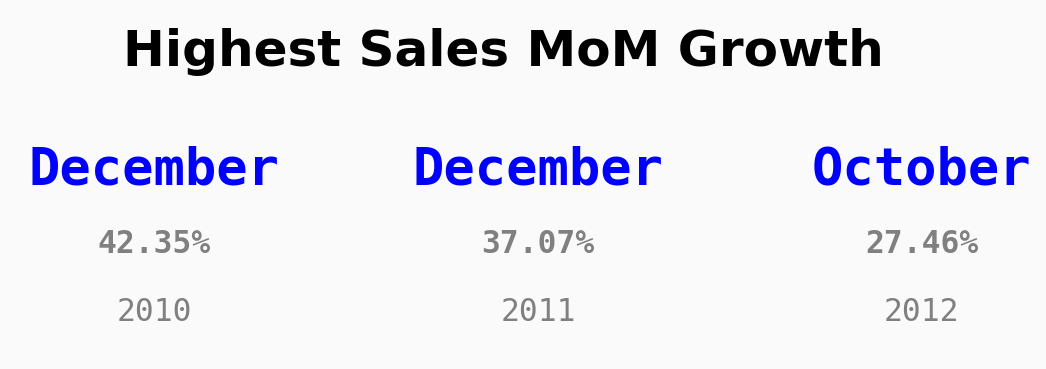

In [16]:
fig = plt.figure(figsize = (6, 3), dpi = 150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace = 0.2, hspace = 0.4)
ax0 = fig.add_subplot(gs[0, 0])

bg_c = '#fafafa'
fig.patch.set_facecolor(bg_c)
ax0.set_facecolor(bg_c)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)

ax0.text(0.7, 0.85, "Highest Sales MoM Growth" , color = 'black', fontsize = 24, fontweight = 'bold', 
         fontfamily = 'sanserif', ha = 'center')
ax0.text(0.2, 0.5, "December", color = 'blue', fontsize = 25, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax0.text(0.2, 0.3, "42.35%", color = 'gray', fontsize = 15, fontfamily = 'monospace',ha = 'center', fontweight = 'bold')
ax0.text(0.2, 0.1, "2010", color = 'gray',fontsize = 15, fontfamily = 'monospace', ha = 'center')
ax0.text(0.75, 0.5, "December", color = 'blue', fontsize = 25, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax0.text(0.75, 0.3, "37.07%", color = 'gray', fontsize = 15, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax0.text(0.75, 0.1, "2011", color = 'gray', fontsize = 15, fontfamily = 'monospace', ha = 'center')
ax0.text(1.3, 0.5, "October", color = 'blue', fontsize = 25, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax0.text(1.3, 0.3, "27.46%", color = 'gray', fontsize = 15, fontfamily = 'monospace', ha = 'center', fontweight = 'bold')
ax0.text(1.3, 0.1, "2012", color = 'gray', fontsize = 15, fontfamily = 'monospace', ha = 'center')

Although Thanksgiving holiday on November has highest sales than the other holiday, December has the highest growth sales happening before Christmas in 2010 and 2011. It stated that in 2012, October become the highest MoM sales growth because we don't have sales data on December 2012.

# Sales Panel Analysis by Store

Text(-2.5, 230000, '\nWalmart Store that have higher sales in the period is Store 20 followed by Store 4 and 14. \nThe insight stop here because we dont know exactly where the store location is.\nBut we will defined how is the trend behind it.\n')

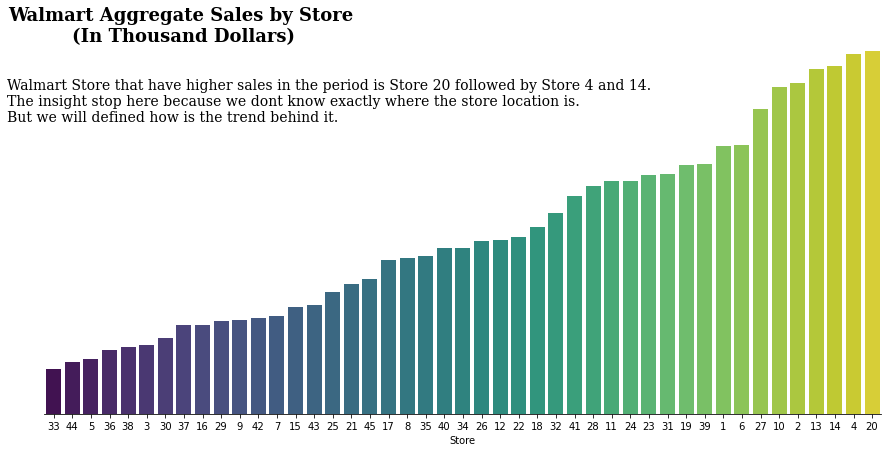

In [17]:
# Which store perform better?

sales_store = pivot.groupby('Store')['Weekly_Sales'].sum().reset_index()

fig, ax = plt.subplots(1, 1, figsize = (15, 7))
sns.barplot(x='Store', y='Weekly_Sales', data=sales_store, order=sales_store.sort_values('Weekly_Sales').Store, ax = ax,
           palette = 'viridis')

for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)
ax.set_yticks([])
ax.set_ylabel('')
ax.text(7, 310000, 'Walmart Aggregate Sales by Store \n(In Thousand Dollars)', fontsize = 18, fontweight = 'bold', 
        fontfamily = 'serif', color = 'black', ha = 'center')
ax.text(-2.5, 230000, '''
Walmart Store that have higher sales in the period is Store 20 followed by Store 4 and 14. 
The insight stop here because we dont know exactly where the store location is.
But we will defined how is the trend behind it.
''', fontsize = 14, fontweight = 'light', 
        fontfamily = 'serif', color = 'black')

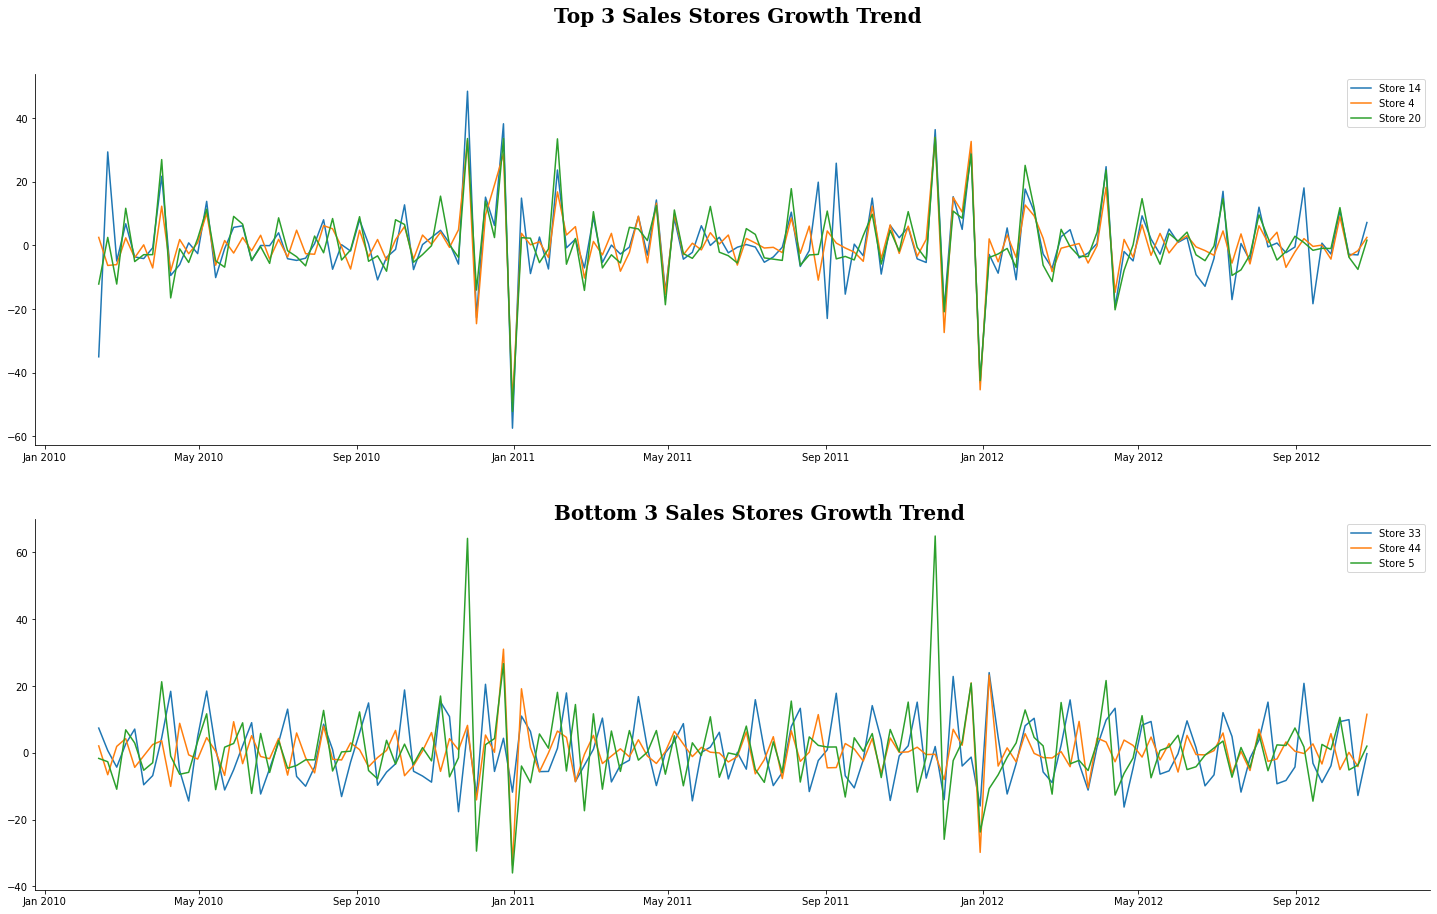

In [18]:
#Highest Store

store14 = pivot[pivot['Store'] == 14][['Date', 'Weekly_Sales']]
store14['roll'] = np.roll(store14['Weekly_Sales'], 1)
store14['weekly_growth'] = round((store14['Weekly_Sales'] - store14['roll']) / store14['roll'] * 100, 2)
store14 = store14.shift(-1)

store4 = pivot[pivot['Store'] == 4][['Date', 'Weekly_Sales']]
store4['roll'] = np.roll(store4['Weekly_Sales'], 1)
store4['weekly_growth'] = round((store4['Weekly_Sales'] - store4['roll']) / store4['roll'] * 100, 2)
store4 = store4.shift(-1)

store20 = pivot[pivot['Store'] == 20][['Date', 'Weekly_Sales']]
store20['roll'] = np.roll(store20['Weekly_Sales'], 1)
store20['weekly_growth'] = round((store20['Weekly_Sales'] - store20['roll']) / store20['roll'] * 100, 2)
store20 = store20.shift(-1)

#Lowest Store
store33 = pivot[pivot['Store'] == 33][['Date', 'Weekly_Sales']]
store33['roll'] = np.roll(store33['Weekly_Sales'], 1)
store33['weekly_growth'] = round((store33['Weekly_Sales'] - store33['roll']) / store33['roll'] * 100, 2)
store33 = store33.shift(-1)

store44 = pivot[pivot['Store'] == 44][['Date', 'Weekly_Sales']]
store44['roll'] = np.roll(store44['Weekly_Sales'], 1)
store44['weekly_growth'] = round((store44['Weekly_Sales'] - store44['roll']) / store44['roll'] * 100, 2)
store44 = store44.shift(-1)

store5 = pivot[pivot['Store'] == 5][['Date', 'Weekly_Sales']]
store5['roll'] = np.roll(store5['Weekly_Sales'], 1)
store5['weekly_growth'] = round((store5['Weekly_Sales'] - store5['roll']) / store5['roll'] * 100, 2)
store5 = store5.shift(-1)

fig, ax = plt.subplots(2, 1, figsize = (25, 15))
sns.lineplot(x =store14['Date'], y = store14['weekly_growth'], ax = ax[0], label = 'Store 14', palette = 'Set2')
sns.lineplot(x =store4['Date'], y = store4['weekly_growth'], ax = ax[0], label = 'Store 4', palette = 'Set2')
sns.lineplot(x =store20['Date'], y = store20['weekly_growth'], ax = ax[0], label = 'Store 20', palette = 'Set2')
#sns.lineplot(x = pivot_table['Date'], y = pivot_table['Temperature'], ax = ax[0], label = 'CPI')

sns.lineplot(x =store33['Date'], y = store33['weekly_growth'], ax = ax[1], label = 'Store 33', palette = 'Set2')
sns.lineplot(x =store44['Date'], y = store44['weekly_growth'], ax = ax[1], label = 'Store 44', palette = 'Set2')
sns.lineplot(x =store5['Date'], y = store5['weekly_growth'], ax = ax[1], label = 'Store 5', palette = 'Set2')

ax0.set_facecolor(bg_c)

for s in ['top', 'right']:
    for i in [0,1]:
        ax[i].spines[s].set_visible(False)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].xaxis.set_major_formatter(years_fmt)

ax[0].text('2011-02', 70, 'Top 3 Sales Stores Growth Trend', color = 'black', fontsize = 20, fontweight = 'bold', 
         fontfamily = 'serif')
ax[1].text('2011-02', 70, 'Bottom 3 Sales Stores Growth Trend', color = 'black', fontsize = 20, fontweight = 'bold', 
         fontfamily = 'serif')

plt.show()

findfont: Font family ['sanserif'] not found. Falling back to DejaVu Sans.


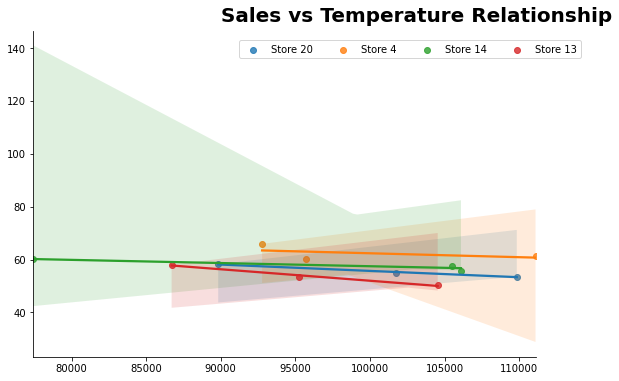

In [19]:
sales_store = sales_store.sort_values('Weekly_Sales', ascending = False)
store_list = list(sales_store['Store'][:4])

sales = pivot.groupby(['Store', 'Year'])['Weekly_Sales'].sum()
temp = pivot.groupby(['Store', 'Year'])['Temperature'].mean()
cpi = pivot.groupby(['Store', 'Year'])['CPI'].mean()
unem = pivot.groupby(['Store', 'Year'])['Unemployment'].mean()
fp = pivot.groupby(['Store', 'Year'])['Fuel_Price'].mean()

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for sto in store_list:
    sns.regplot(x = sales[sto].values, y = temp[sto].values, label = sto)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    
legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Store 20', 'Store 4', 'Store 14', 'Store 13'], ncol = 4, bbox_to_anchor = (0.75, 0.9), 
          loc = 'lower center')

ax.text(90000, 150, "Sales vs Temperature Relationship" , color = 'black', fontsize = 20, fontweight = 'bold', 
         fontfamily = 'sanserif')

plt.show()

Here we test the relationship between temperature and sales since this variable has the highest correlation among all feature. As we see that the slope (relative change in dependent variable if independent variable change) are small in all highest sales top 4 store. What we are gonna do next is using econometric to clarify the relationship.



Note: We better do this econometric domain using SPSS/Stata software, but for simplicity purpose we use statmodels and linearregression library.

# Econometrics Analysis: Does Macroeconomic Variable Affect Weekly Sales?

In [39]:
#building panel dataset format
panel_data
#dates = panel_data.index.get_level_values('Date').to_list()
#panel_data['Date'] = pd.Categorical(dates)
#panel_data.drop(['Month', 'Year', 'Holiday_Flag'], axis = 1, inplace = True)
#panel_data.to_excel('Walmart Data.xlsx')

CPI  Fuel_Price  Temperature  Unemployment  Weekly_Sales  \
Store Date                                                                      
1     2010-02-05  211.10       2.572        42.31         8.106      1643.691   
      2010-02-12  211.24       2.548        38.51         8.106      1641.957   
      2010-02-19  211.29       2.514        39.93         8.106      1611.968   
      2010-02-26  211.32       2.561        46.63         8.106      1409.728   
      2010-03-05  211.35       2.625        46.50         8.106      1554.807   
...                  ...         ...          ...           ...           ...   
45    2012-09-28  192.01       3.997        64.88         8.684       713.174   
      2012-10-05  192.17       3.985        64.89         8.667       733.455   
      2012-10-12  192.33       4.000        54.47         8.667       734.464   
      2012-10-19  192.33       3.969        56.47         8.667       718.126   
      2012-10-26  192.31       3.882        58.85         8.667       760.281   

                       Date  
Store Date                   
1     2010-02-05 2010-02-05  
      2010-02-12 2010-02-12  
      2010-02-19 2010-02-19  
      2010-02-26 2010-02-26  
      2010-03-05 2010-03-05  
...                     ...  
45    2012-09-28 2012-09-28  
      2012-10-05 2012-10-05  
      2012-10-12 2012-10-12  
      2012-10-19 2012-10-19  
      2012-10-26 2012-10-26  

[6435 rows x 6 columns]

In [24]:
#building dependent and independent variable
independent = sm.tools.tools.add_constant(panel_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
dependent = panel_data['Weekly_Sales']

#fitting variable into panel OLS method
model = PooledOLS(dependent, independent)
pooledOLS_res = model.fit(cov_type='clustered', cluster_entity=True)

residuals = pooledOLS_res.resids

In [26]:
pooled_data = pd.concat([panel_data, residuals], axis = 1)
pooled_data = pooled_data.drop(['Date'], axis = 1).fillna(0)

#check regression assumption (heteroskedasticity)
breusch_pagan_test = list(het_breuschpagan(pooled_data['residual'], independent))
label_aut = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
result_auto = pd.Series(breusch_pagan_test, index = label_aut)
result_auto[3]

3.537082038929619e-16

In [27]:
#check regression assumption (autocorrelation)
durbin_watson_test = durbin_watson(pooled_data['residual']) 
print(durbin_watson_test)

0.1125702124046284


In [33]:
pooled_data = np.log(panel_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']])

independent = sm.tools.tools.add_constant(panel_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
dependent = panel_data['Weekly_Sales']

#Fixed Effect
model_fe = PanelOLS(dependent, independent, entity_effects = True) 
fe_reg = model_fe.fit() 

#Random Effect
model_re = RandomEffects(dependent, independent)
re_reg = model_re.fit()

<ipython-input-33-47251ac664d4>:1: RuntimeWarning: invalid value encountered in log
  pooled_data = np.log(panel_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']])


In [34]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_reg, re_reg)
print('p-Value: ' + str(hausman_results[2]))

p-Value: 0.5361539855586297


In [35]:
print(re_reg)

                        RandomEffects Estimation Summary                        
Dep. Variable:           Weekly_Sales   R-squared:                        0.0204
Estimator:              RandomEffects   R-squared (Between):             -0.0584
No. Observations:                6435   R-squared (Within):               0.0209
Date:                Wed, Aug 25 2021   R-squared (Overall):             -0.0519
Time:                        12:34:51   Log-likelihood                -4.183e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      33.542
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(4,6430)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             33.542
                            